In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/day.csv')

df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
df = df.loc[:, ['dteday', 
                'workingday', 
                'casual', 
                'registered', 
                'cnt']]

In [4]:
# Por dia, em média, 4.504 bicicletas são alugadas.
# Falando sobre tipos de usuários, por dia, em média, 848 são usuários casuais
# e 3656 são usuários registrados.

df[['casual', 'registered', 'cnt']].mean()

casual         848.176471
registered    3656.172367
cnt           4504.348837
dtype: float64

In [5]:
# Olhando para mediana não vemos uma distorção muito grande em relação à média.
# Em 50% dos dias tivemos o aluguel de 4.548 bicicletas. 
# Pelo fato da mediana ter valor maior que a média, 
# significa que nossa distribuição de aluguel de bicicletas diárias
# tem uma leve calda para a esquerda.

df[['casual', 'registered', 'cnt']].median()

casual         713.0
registered    3662.0
cnt           4548.0
dtype: float64

## Business Question #1 

**Is demand for bicycle rental _different_ between workdays and weekends?**

In [6]:
# Ao olhar para as médias, percebemos que sim, os valores são diferentes.
# Neste caso, a demanda durante os dias da semana é maior.
# Observamos o mesmo fenômeno ao observar as medianas.

df.groupby('workingday').cnt.describe().T

workingday,0,1
count,231.000000,500.000000
mean,4330.168831,4584.820000
std,2052.141245,1878.415583
min,605.000000,22.000000
25%,2710.500000,3344.250000
50%,4459.000000,4582.000000
75%,5907.500000,5987.500000
max,8714.000000,8362.000000


<AxesSubplot:title={'center':'cnt'}, xlabel='workingday'>

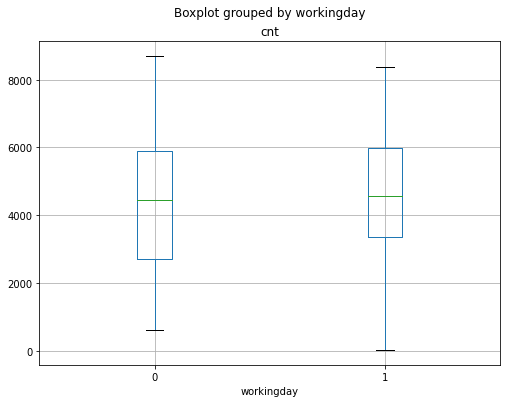

In [7]:
# Aí, vem a pergunta pulo-do-gato: Esse diferença é estatisticamente significativa?
# Ou seja, qual a probabilidade de termos obtido essa diferença por acaso? 
# Ou também: Qual a probabilidade de se obter essa diferença? É alta?
# Se for uma probabilidade alta, podemos dizer que essas são amostras que vem da mesma população, 
# e não de populações com caractéristicas diferentes.

df.boxplot(column=['cnt'], 
           by='workingday', figsize=(8, 6)
          )

## Hypothesis #1

<b>Null hypothesis (H0):</b> u1 = u2, which translates to the mean of `sample_01` is equal to the mean of `sample 02`

<b>Alternative hypothesis (H1):</b> u1 != u2, which translates to the means of `sample01` is not equal to `sample 02`

## Test #1
* 2 independent groups: count on workdays and weekends
* if `normality `-> `t-test` (checking variances!)
* else -> `mann-whitney`
* signficance level: 5%

In [8]:
sample_01 = df.query('workingday == 1').reset_index(drop=True)
sample_02 = df.query('workingday == 0').reset_index(drop=True)

In [9]:
sample_01.shape, sample_02.shape

((500, 5), (231, 5))

In [10]:
# take a sample of the size of the smallest to compare.

sample_01 = sample_01.sample(231,random_state=42).reset_index(drop=True)

sample_01.shape, sample_02.shape

((231, 5), (231, 5))

In [11]:
# teste paramétrico
stats.ttest_ind(sample_01['cnt'], sample_02['cnt'])

Ttest_indResult(statistic=0.7125247222345579, pvalue=0.476501159234212)

In [12]:
stats.ttest_ind(sample_01['cnt'], sample_02['cnt'], equal_var=False)

Ttest_indResult(statistic=0.7125247222345579, pvalue=0.47650494875175897)

In [13]:
# teste não-paramétrico
stats.mannwhitneyu(sample_01['cnt'], sample_02['cnt'])

MannwhitneyuResult(statistic=27648.5, pvalue=0.5001342759408872)

In [ ]:
# Pelos dois testes executados, conseguimos observar que a diferença
# entre o aluguel de bicicletas durante a semana e finais de semana 
# não é estatisticamente significativo, pois para o `significance level` 
# de 5% ambos recaem num valor superior.

## Checking Assumptions

### Homogeneity of variance (Homoscedasticity)

- T-tests and ANOVA (analysis of variances) <u>assumes</u> that the samples to be compared <b>have same variance</b> (i.e, they have homogeneity of variance). In reality, t and F statistics (the statistics used by these tests) are actually robust to violations in this assumption if the samples have <b>roughly the same size</b>.


- The most common assessment for homogeneity of variance is <u>Levene's test</u>. The Levene's test uses an F-test to test the null hypothesis that the variance is equal across groups. This means: if we perform Levene's test and obtain a p value less than .05, it indicates that we can <u> reject the hypothesis that variance is equal across groups </u>, hence a violation of the homscedasticity assumption.


https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html

In [14]:
sample_01['cnt'].var()

3428633.241031432

In [15]:
sample_02['cnt'].var()

4211283.688763411

In [16]:
# we want to check whether the variable `cnt` in our dataframe have same variance across samples:


# hipotese nula do teste de levene é 
# H0: as variâncias entre as amostras são iguais
# H1: as variâncias entre as amostras são diferentes

stats.levene(sample_01['cnt'], sample_02['cnt'])

LeveneResult(statistic=3.979889033842622, pvalue=0.04663610361247089)

In [ ]:
# Como pvalue < 0.05, novamente, posso rejeitar a hipótese de que as variâncias são iguais.

### Normal distribution  of residuals

Another important assumption of these tests we are performing is: the residuals between the groups needs to be normally distributed - that is, if we subtract the sample values, we need to obtain a gaussian distribution.

#### Checking difference between two pair points


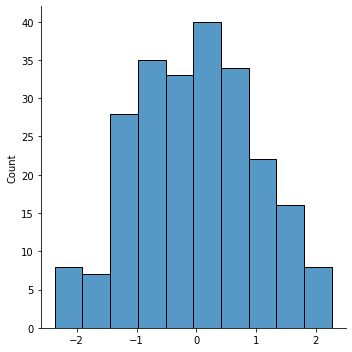

In [17]:
from sklearn.preprocessing import scale
diff = scale(sample_01['cnt'] - sample_02['cnt'])

sns.displot(diff);

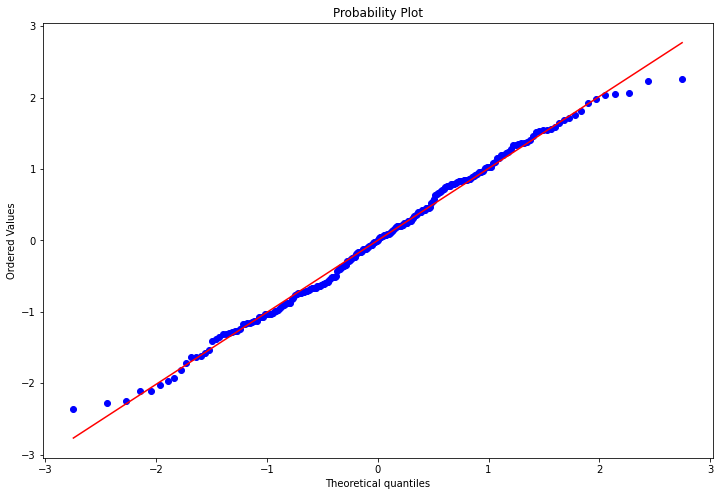

In [18]:
plt.figure(figsize=(12, 8))

stats.probplot(diff, plot=plt, dist='norm')

plt.show()

#### Checking normal distribution by `shapiro method`

The `shapiro-wilk` test is a statistical test that numerically accesses whether a distribution of a sample comes from a population that had a gaussian distribution.

**The null-hypothesis of the `shapiro-wilk` test is, thus, that your sample comes from a normal distribution.**

If the p-value is greater than 0.05, it means you cannot reject the hypothesis that the sample comes from a population that has a normal distribution.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

https://stats.stackexchange.com/questions/15696/interpretation-of-shapiro-wilk-test

In [19]:
stats.shapiro(diff)

ShapiroResult(statistic=0.9917702674865723, pvalue=0.22145463526248932)

## Business Question #2

**Is demand for bicycle rental on workdays greater than demand on weekends?**

In [20]:
stats.ttest_ind(sample_01['cnt'], 
                sample_02['cnt'], 
                equal_var=False,
                alternative='greater' #one tailed test
           )

Ttest_indResult(statistic=0.7125247222345579, pvalue=0.23825247437587949)

## Business Question #3
Does registered users use the service of bike rental more than casual users?

<AxesSubplot:>

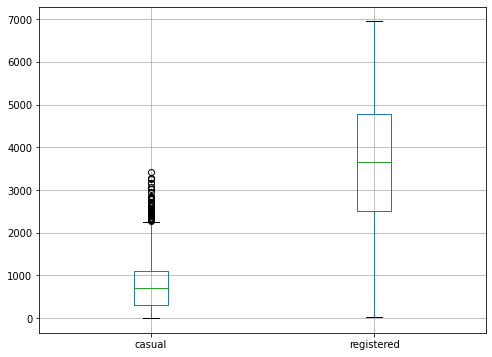

In [21]:
df.boxplot(column=['casual', 'registered'], figsize=(8, 6))

In [22]:
stats.ttest_ind(df['registered'],
                df['casual'], 
                alternative='greater'
           )

Ttest_indResult(statistic=44.53675092663381, pvalue=1.2697038750164425e-274)

In [23]:
# teste não-paramétrico
stats.mannwhitneyu(df['registered'], 
                   df['casual'],
                  alternative='greater')

MannwhitneyuResult(statistic=509204.0, pvalue=7.638175147993202e-198)